# Custom Synthetic Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate a synthetic dataset
np.random.seed(0)
num_samples = 1000
num_features = 2

# Generate random data
X = np.random.randn(num_samples, num_features)

# Define multiple thresholds to create multiple classes
thresholds = [-1.0, 1.0]
# Calculate the sum of feature values for each row
sum_features = np.sum(X, axis=1)
# Initialize an array to store the class labels
y = np.zeros_like(sum_features)
# Assign class 0 if sum < thresholds[0]
y[sum_features < thresholds[0]] = 0
# Assign class 1 if thresholds[0] <= sum < thresholds[1]
y[(sum_features >= thresholds[0]) & (sum_features < thresholds[1])] = 1
# Assign class 2 if sum >= thresholds[1]
y[sum_features >= thresholds[1]] = 2
y = y.astype(int)

In [2]:
# Saving the Dataset
df = pd.DataFrame({"X_1": X[:, 0], "X_2": X[:, 1], "y": y})
df.to_csv('sample_data.csv', index=False)

In [3]:
# Convert y to one-hot encoding
def one_hot_encode(y, num_classes):
    y_encoded = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        y_encoded[i, y[i]] = 1
    return y_encoded

num_classes = len(thresholds) + 1
y_encoded = one_hot_encode(y, num_classes)

# Split the dataset into training and validation sets
split_ratio = 0.8
test_samples = 10
split_idx = int(split_ratio * (num_samples-test_samples))

X_train, y_train = X[:split_idx], y_encoded[:split_idx]
X_val, y_val = X[split_idx:-test_samples], y_encoded[split_idx:-test_samples]
X_test, y_test = X[-test_samples:], y_encoded[-test_samples:]

print(f"Training data: {len(X_train)} data")
print(f"Validation data: {len(X_val)} data")
print(f"Test data: {len(X_test)} data")

Training data: 792 data
Validation data: 198 data
Test data: 10 data


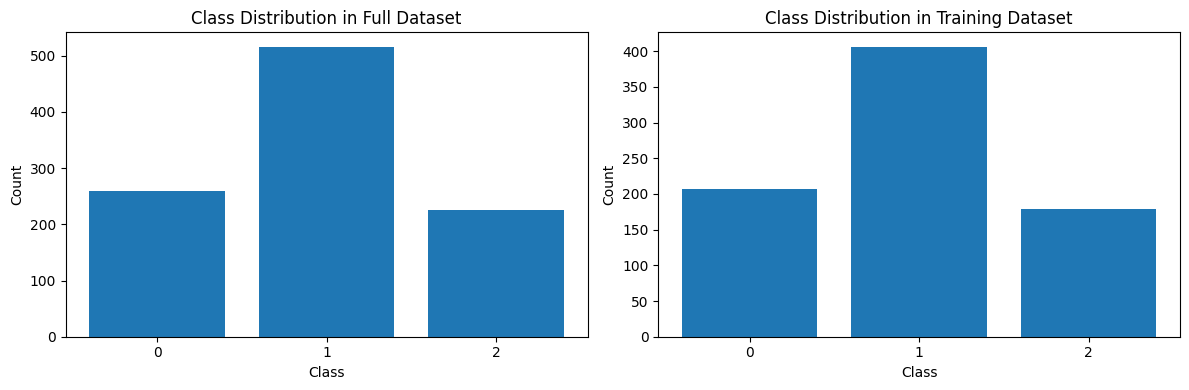

In [4]:
# Calculate the count of each category in the original non-encoded y (full dataset)
class_counts_full_y = np.bincount(y)

# Calculate the count of each category in the original non-encoded y for training data
class_counts_train_y = np.bincount(y_train.argmax(axis=1))

# Create subplots for both plots side by side
plt.figure(figsize=(12, 4))

# Plot for full y
plt.subplot(1, 2, 1)
plt.bar(range(len(class_counts_full_y)), class_counts_full_y, tick_label=range(len(class_counts_full_y)))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Full Dataset')

# Plot for training data y
plt.subplot(1, 2, 2)
plt.bar(range(len(class_counts_train_y)), class_counts_train_y, tick_label=range(len(class_counts_train_y)))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Dataset')

plt.tight_layout()
plt.show()

Epoch 0/500: Train Loss = 1.7949, Train Accuracy = 0.1427, Val Loss = 1.8170, Val Accuracy = 0.1162
Epoch 10/500: Train Loss = 1.5978, Train Accuracy = 0.1894, Val Loss = 1.6109, Val Accuracy = 0.1768
Epoch 20/500: Train Loss = 1.4281, Train Accuracy = 0.2424, Val Loss = 1.4336, Val Accuracy = 0.2323
Epoch 30/500: Train Loss = 1.2845, Train Accuracy = 0.3093, Val Loss = 1.2845, Val Accuracy = 0.2828
Epoch 40/500: Train Loss = 1.1650, Train Accuracy = 0.3851, Val Loss = 1.1614, Val Accuracy = 0.3434
Epoch 50/500: Train Loss = 1.0666, Train Accuracy = 0.4634, Val Loss = 1.0610, Val Accuracy = 0.4293
Epoch 60/500: Train Loss = 0.9859, Train Accuracy = 0.5227, Val Loss = 0.9797, Val Accuracy = 0.5253
Epoch 70/500: Train Loss = 0.9197, Train Accuracy = 0.5922, Val Loss = 0.9136, Val Accuracy = 0.6010
Epoch 80/500: Train Loss = 0.8653, Train Accuracy = 0.6477, Val Loss = 0.8597, Val Accuracy = 0.6465
Epoch 90/500: Train Loss = 0.8202, Train Accuracy = 0.6869, Val Loss = 0.8151, Val Accuracy 

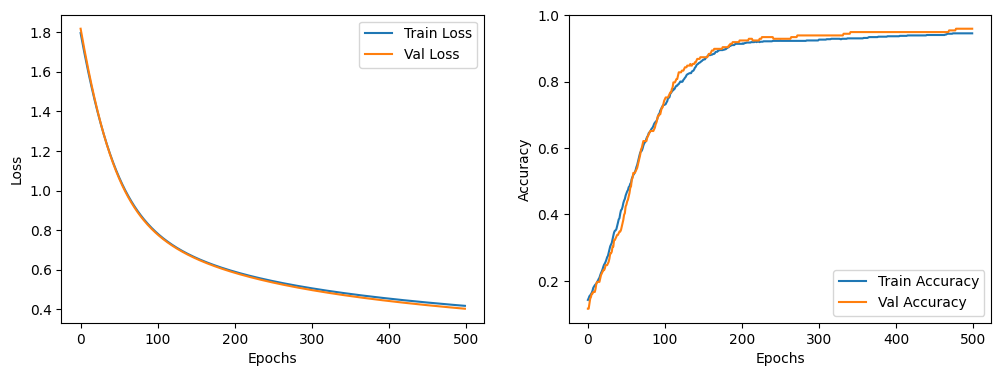

In [5]:
# Define the linear model
class LinearClassifier:
    def __init__(self, input_dim, output_dim, seed=None):
        if seed is not None:
            np.random.seed(seed)

        self.W = np.random.randn(input_dim, output_dim)
        self.b = np.zeros((1, output_dim))

    def forward(self, X):
        self.X = X
        self.Z = np.dot(X, self.W) + self.b
        self.output = self.softmax(self.Z)
        return self.output

    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

    def backward(self, dA, learning_rate):
        self.X_train = X_train
        m = self.X.shape[0]
        dZ = dA
        dW = np.dot(self.X_train.T, dZ) / m
        db = np.sum(dZ, axis=0, keepdims=True) / m
        self.W -= learning_rate * dW
        self.b -= learning_rate * db

    def train(self, X_train, y_train, X_val, y_val, learning_rate=0.01, num_epochs=100):
        self.loss_history_train = []
        self.loss_history_val = []
        self.accuracy_history_train = []
        self.accuracy_history_val = []

        for epoch in range(num_epochs):
            # Forward pass
            y_pred_train = self.forward(X_train)
            y_pred_val = self.forward(X_val)

            # Compute loss
            loss_train = self.cross_entropy_loss(y_pred_train, y_train)
            loss_val = self.cross_entropy_loss(y_pred_val, y_val)
            self.loss_history_train.append(loss_train)
            self.loss_history_val.append(loss_val)

            # Compute accuracy
            acc_train = self.compute_accuracy(y_pred_train, y_train)
            acc_val = self.compute_accuracy(y_pred_val, y_val)
            self.accuracy_history_train.append(acc_train)
            self.accuracy_history_val.append(acc_val)

            # Backward pass
            self.backward(y_pred_train - y_train, learning_rate)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{num_epochs}: Train Loss = {loss_train:.4f}, Train Accuracy = {acc_train:.4f}, Val Loss = {loss_val:.4f}, Val Accuracy = {acc_val:.4f}")

        print("Training complete.")

    def cross_entropy_loss(self, y_pred, y_true):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10)) / m

    def compute_accuracy(self, y_pred, y_true):
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true_class = np.argmax(y_true, axis=1)
        accuracy = np.mean(y_pred_class == y_true_class)
        return accuracy

    def predict(self, X_test):
        y_pred_test = self.forward(X_test)
        y_pred_class = np.argmax(y_pred_test, axis=1)
        return y_pred_class

# Define hyperparameters
input_dim = num_features
output_dim = num_classes
seed_for_weights = 42
learning_rate = 0.01
num_epochs = 500

# Create and train the model
model = LinearClassifier(input_dim, output_dim, seed=seed_for_weights)
model.train(X_train, y_train, X_val, y_val, learning_rate, num_epochs)

# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model.loss_history_train, label='Train Loss')
plt.plot(model.loss_history_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.accuracy_history_train, label='Train Accuracy')
plt.plot(model.accuracy_history_val, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [7]:
# Create a DataFrame for the test data
test_data = pd.DataFrame(data=X_test, columns=['X_1', 'X_2'])
y_pred_test_class = model.predict(X_test)

# Add columns for true class and predicted class
test_data['True Class'] = y_test.argmax(axis=1)  # Convert one-hot encoded true labels to class labels
test_data['Predicted Class'] = y_pred_test_class

# Output the test data prediction
test_data

,X_1,X_2,True Class,Predicted Class
0,-0.789102,0.001248,1,1
1,-0.159940,-0.831957,1,1
2,-0.598150,-1.520039,0,0
3,0.417854,-0.040019,1,1
4,-1.259787,0.028621,0,0
5,1.342622,-0.739936,1,1
6,1.315138,-0.323457,1,1
7,0.197828,0.097751,1,1
8,1.401523,0.158434,2,2
9,-1.141901,-1.310970,0,0
